<a href="https://colab.research.google.com/github/Weverton-Vitor/qualifact-course/blob/main/x_ray_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Inteligência Artificial aplicada à Visão Computacional**

**Capítulo 5: Visão Computacional aplicada ao reconhecimento de imagem**



<p align="justify">

Todos os direitos reservados à Facti, 2024
<p>

[www.qualifacti.com.br](https://)

---

<p align="justify">
É importante esclarecer que estas atividades não compõem a avaliação e não haverá correção formal por parte dos instrutores; o objetivo é a autoaprendizagem e prática.
<p>

---

# ETAPA CONSOLIDAR

# **Recado importante**


Olá,
<p align="justify">
Como parte do capítulo de <b>reconhecimento de imagens</b>, gostaríamos de ressaltar a importância de realizar as atividades de implementação fornecidas. Estas atividades são cuidadosamente desenhadas para reforçar o conteúdo apresentado.
Lembre-se, a implementação é uma habilidade que se aprimora com a prática. Ao aplicar os conceitos aprendidos, especialmente por meio da escrita e execução de códigos, você ganhará uma compreensão mais profunda e prática dos modelos.
Encorajamos todos a dedicar tempo a essas atividades. Ao fazer isso, você não apenas reforçará o que foi ensinado, mas também desenvolverá as habilidades essenciais de resolução de problemas e depuração de código.

Lembrem-se: não basta apenas aprender, é preciso codificar! O caminho para dominar os modelos começa com a experiência prática.

Atenciosamente,

Júlio e Marcelo
<p>

---

# Estudo de Caso

Reconhecimento de imagens médicas

1. Importando as bibliotecas:

In [1]:
import numpy as np
import pandas as pd

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.utils import to_categorical

In [3]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
import requests
import zipfile

2. Definindo as propriedades das imagens:

In [4]:
# Parâmtros de largura, altura, dimensões e quantidade de canais
Image_Width=128
Image_Height=128
Image_Size=(Image_Width,Image_Height)
Image_Channels=3

In [8]:
with zipfile.ZipFile('/content/raio-x-torax.zip', 'r') as file:
  file.extractall('./')

3. Preparando o conjunto de dados para o modelo de treinamento:

In [9]:
filenames=os.listdir('/content/raio-x-torax/treino')

# Após realizar o download e descompactar a pasta raio-x-torax.zip, localize o caminho correto do local
# da pasta. Você precisará acessar a pasta treino. Note que a cada pasta, é necessário o uso de barras
# duplas invertivas.

In [10]:
# Criando as categorias para o modelo
categories=[]
for f_name in filenames:
    category=f_name.split('.')[0]
    if category=='pneumonia':
        categories.append(1) # estabelecendo pneumonia como categoria 1
    else:
        categories.append(0) # estabelecendo normal como categoria 0

df=pd.DataFrame({
    'filename':filenames,
    'category':categories
})

df.head(80)

,filename,category
0,pneumonia.6.jpeg,1
1,normal.16.jpg,0
2,pneumonia.78.jpeg,1
3,pneumonia.86.jpeg,1
4,normal.20.jpg,0
...,...,...
75,normal.90.jpg,0
76,pneumonia.89.jpeg,1
77,pneumonia.97.jpeg,1
78,normal.5.jpg,0


<Axes: >

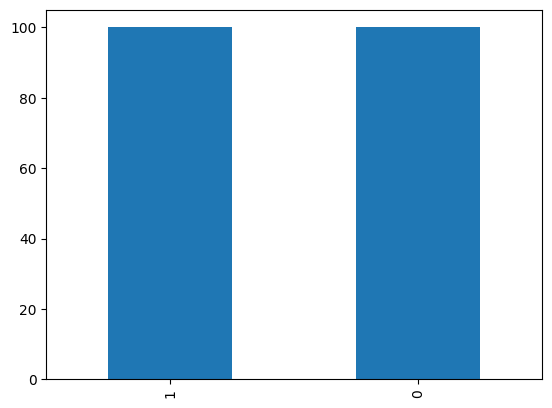

In [11]:
# Verificando a quantidade de imagens em cada categoria
df['category'].value_counts().plot.bar()

4. Criando o modelo da rede neural:

In [12]:
# Implementando o modelo sequencial e suas camadas de rede neural
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,\
     Dropout,Flatten,Dense,Activation,\
     BatchNormalization

model=Sequential()

model.add(Conv2D(32,(3,3),activation='relu',input_shape=(Image_Width,Image_Height,Image_Channels)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2,activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='rmsprop',metrics=['accuracy'])

5. Analisando o modelo:

In [14]:
# Visualizando o modelo sequencial e suas camadas
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

6. Definindo as chamadas de retorno e taxa de aprendizado:
* chamada de retorno é um conjunto de funções a serem aplicadas em uma determinada etapa do procedimento do treinamento. Isso incluirá interromper o treinamento quando atingir uma certa pontuação de precisão/perda, para salvar o modelo após cada época bem-sucedida e ajustar as taxas de aprendizado
    * Early Stop: Para evitar overfitting, interromperemos o aprendizado após 10 épocas e o valor val_loss não diminuirá.
    * Redução da taxa de aprendizado: Reduziremos a taxa de aprendizado quando a precisão não aumentar em 2 etapas.

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc',patience = 2,verbose = 1,factor = 0.5,min_lr = 0.00001)
callbacks = [earlystop,learning_rate_reduction]

7. Gerenciando os dados:

In [15]:
df["category"] = df["category"].replace({0:'normal', 1:'pneumonia'})
train_df,validate_df = train_test_split(df, test_size=0.20, random_state=42)

train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

total_train=train_df.shape[0]
total_validate=validate_df.shape[0]
batch_size=15

8. Gerando dados de treinamento e validação:

In [18]:
train_datagen = ImageDataGenerator(rotation_range=15,
                                   rescale=1./255,
                                   shear_range=0.1,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1
                                  )

train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    "/content/raio-x-torax/treino",
# note que o caminho para a pasta treino deverá novamente ser apontado. Atente-se para não apagar as aspas e barras duplas.
                                                    x_col='filename',
                                                    y_col='category',
                                                    target_size=Image_Size,
                                                    class_mode='categorical',
                                                    batch_size=batch_size)

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df,
    "/content/raio-x-torax/treino",
# note que o caminho para a pasta treino deverá novamente ser apontado. Atente-se para não apagar as aspas e barras duplas.
    x_col='filename',
    y_col='category',
    target_size=Image_Size,
    class_mode='categorical',
    batch_size=batch_size
)

test_datagen = ImageDataGenerator(rotation_range=15,
                                  rescale=1./255,
                                  shear_range=0.1,
                                  zoom_range=0.2,
                                  horizontal_flip=True,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1)


Found 160 validated image filenames belonging to 2 classes.
Found 40 validated image filenames belonging to 2 classes.


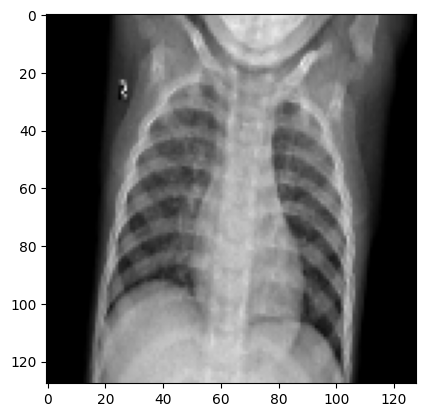

In [19]:
# Visualizando as imagens dentro do modelo
x , y  = train_generator.next()
for i in range(0,1):
    random_image = x[i]
    plt.imshow(random_image)
    plt.show()

9. Treinamento do modelo:

In [20]:
epochs=10 # quantidade de épocas de treinamento. É possível aumentar ou dimunir a quantidade.
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks,
)

Epoch 1/10
10/10 [==============================] - ETA: 0s - loss: 1.4358 - accuracy: 0.6621

10/10 [==============================] - 16s 1s/step - loss: 1.4358 - accuracy: 0.6621 - val_loss: 0.8224 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 2/10
10/10 [==============================] - ETA: 0s - loss: 0.6147 - accuracy: 0.8138

10/10 [==============================] - 13s 1s/step - loss: 0.6147 - accuracy: 0.8138 - val_loss: 4.2291 - val_accuracy: 0.5667 - lr: 0.0010
Epoch 3/10
10/10 [==============================] - ETA: 0s - loss: 0.6122 - accuracy: 0.8276

10/10 [==============================] - 15s 2s/step - loss: 0.6122 - accuracy: 0.8276 - val_loss: 8.6552 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 4/10
10/10 [==============================] - ETA: 0s - loss: 0.5006 - accuracy: 0.7931

10/10 [==============================] - 12s 1s/step - loss: 0.5006 - accuracy: 0.7931 - val_loss: 10.4590 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 5/10
10/10 [==============================] - ETA: 0s - loss: 0.6128 - accuracy: 0.8000

10/10 [==============================] - 12s 1s/step - loss: 0.6128 - accuracy: 0.8000 - val_loss: 11.9977 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 6/10
10/10 [==============================] - ETA: 0s - loss: 0.4611 - accuracy: 0.8552

10/10 [==============================] - 11s 1s/step - loss: 0.4611 - accuracy: 0.8552 - val_loss: 12.5120 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 7/10
10/10 [==============================] - ETA: 0s - loss: 0.5856 - accuracy: 0.8276

10/10 [==============================] - 12s 1s/step - loss: 0.5856 - accuracy: 0.8276 - val_loss: 13.0275 - val_accuracy: 0.4667 - lr: 0.0010
Epoch 8/10
10/10 [==============================] - ETA: 0s - loss: 0.4962 - accuracy: 0.8069

10/10 [==============================] - 13s 1s/step - loss: 0.4962 - accuracy: 0.8069 - val_loss: 13.4544 - val_accuracy: 0.4333 - lr: 0.0010
Epoch 9/10
10/10 [==============================] - ETA: 0s - loss: 0.4247 - accuracy: 0.8138

10/10 [==============================] - 11s 1s/step - loss: 0.4247 - accuracy: 0.8138 - val_loss: 13.2450 - val_accuracy: 0.5333 - lr: 0.0010
Epoch 10/10
10/10 [==============================] - ETA: 0s - loss: 0.4710 - accuracy: 0.8345

10/10 [==============================] - 12s 1s/step - loss: 0.4710 - accuracy: 0.8345 - val_loss: 14.5314 - val_accuracy: 0.5000 - lr: 0.0010


10. Salvando o modelo:

In [21]:
model.save("modelo_raio-x-torax_10epoch.h5") # documento gerado com a base de treinamento.

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


11. Preparando os dados de teste:

In [22]:
test_filenames = os.listdir("/content/raio-x-torax/teste")
# note que o caminho para a pasta teste deverá novamente ser apontado. Atente-se para não apagar as aspas e barras duplas.

test_df = pd.DataFrame({
    'filename': test_filenames
})

12. Testando os dados de treinamento:

In [25]:
test_generator = train_datagen.flow_from_dataframe(test_df,
                                                   '/content/raio-x-torax/teste',
# note que o caminho agora é para a pasta TESTE. Atente-se para não apagar as aspas e barras duplas.
                                                   x_col='filename',
                                                   y_col=None,
                                                   target_size=Image_Size,
                                                   class_mode=None,
                                                   batch_size=batch_size
                                                   )

nb_samples = test_df.shape[0]

Found 100 validated image filenames.


13. Fazendo as previsões das categorias:

In [26]:
predict = model.predict(test_generator, steps=np.ceil(nb_samples/batch_size))

7/7 [==============================] - 3s 351ms/step


In [30]:
# Raw predicts
predict[:10]

array([[8.71427666e-15, 9.99999940e-01],
       [1.05252727e-13, 9.99999940e-01],
       [5.43533165e-15, 9.99999940e-01],
       [1.37567875e-14, 9.99999940e-01],
       [6.17727322e-15, 9.99999940e-01],
       [2.59659671e-13, 9.99999940e-01],
       [4.54859573e-14, 9.99999940e-01],
       [2.39208677e-14, 9.99999940e-01],
       [5.69743159e-14, 1.00000000e+00],
       [1.72208168e-14, 1.00000000e+00]], dtype=float32)

14. Convertendo os labels em categorias:

In [31]:
test_df['category'] = np.argmax(predict, axis=-1)

label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

test_df['category'] = test_df['category'].replace({ 'pneumonia': 1, 'normal': 0 })

15. Visualizando os resultados da previsão:

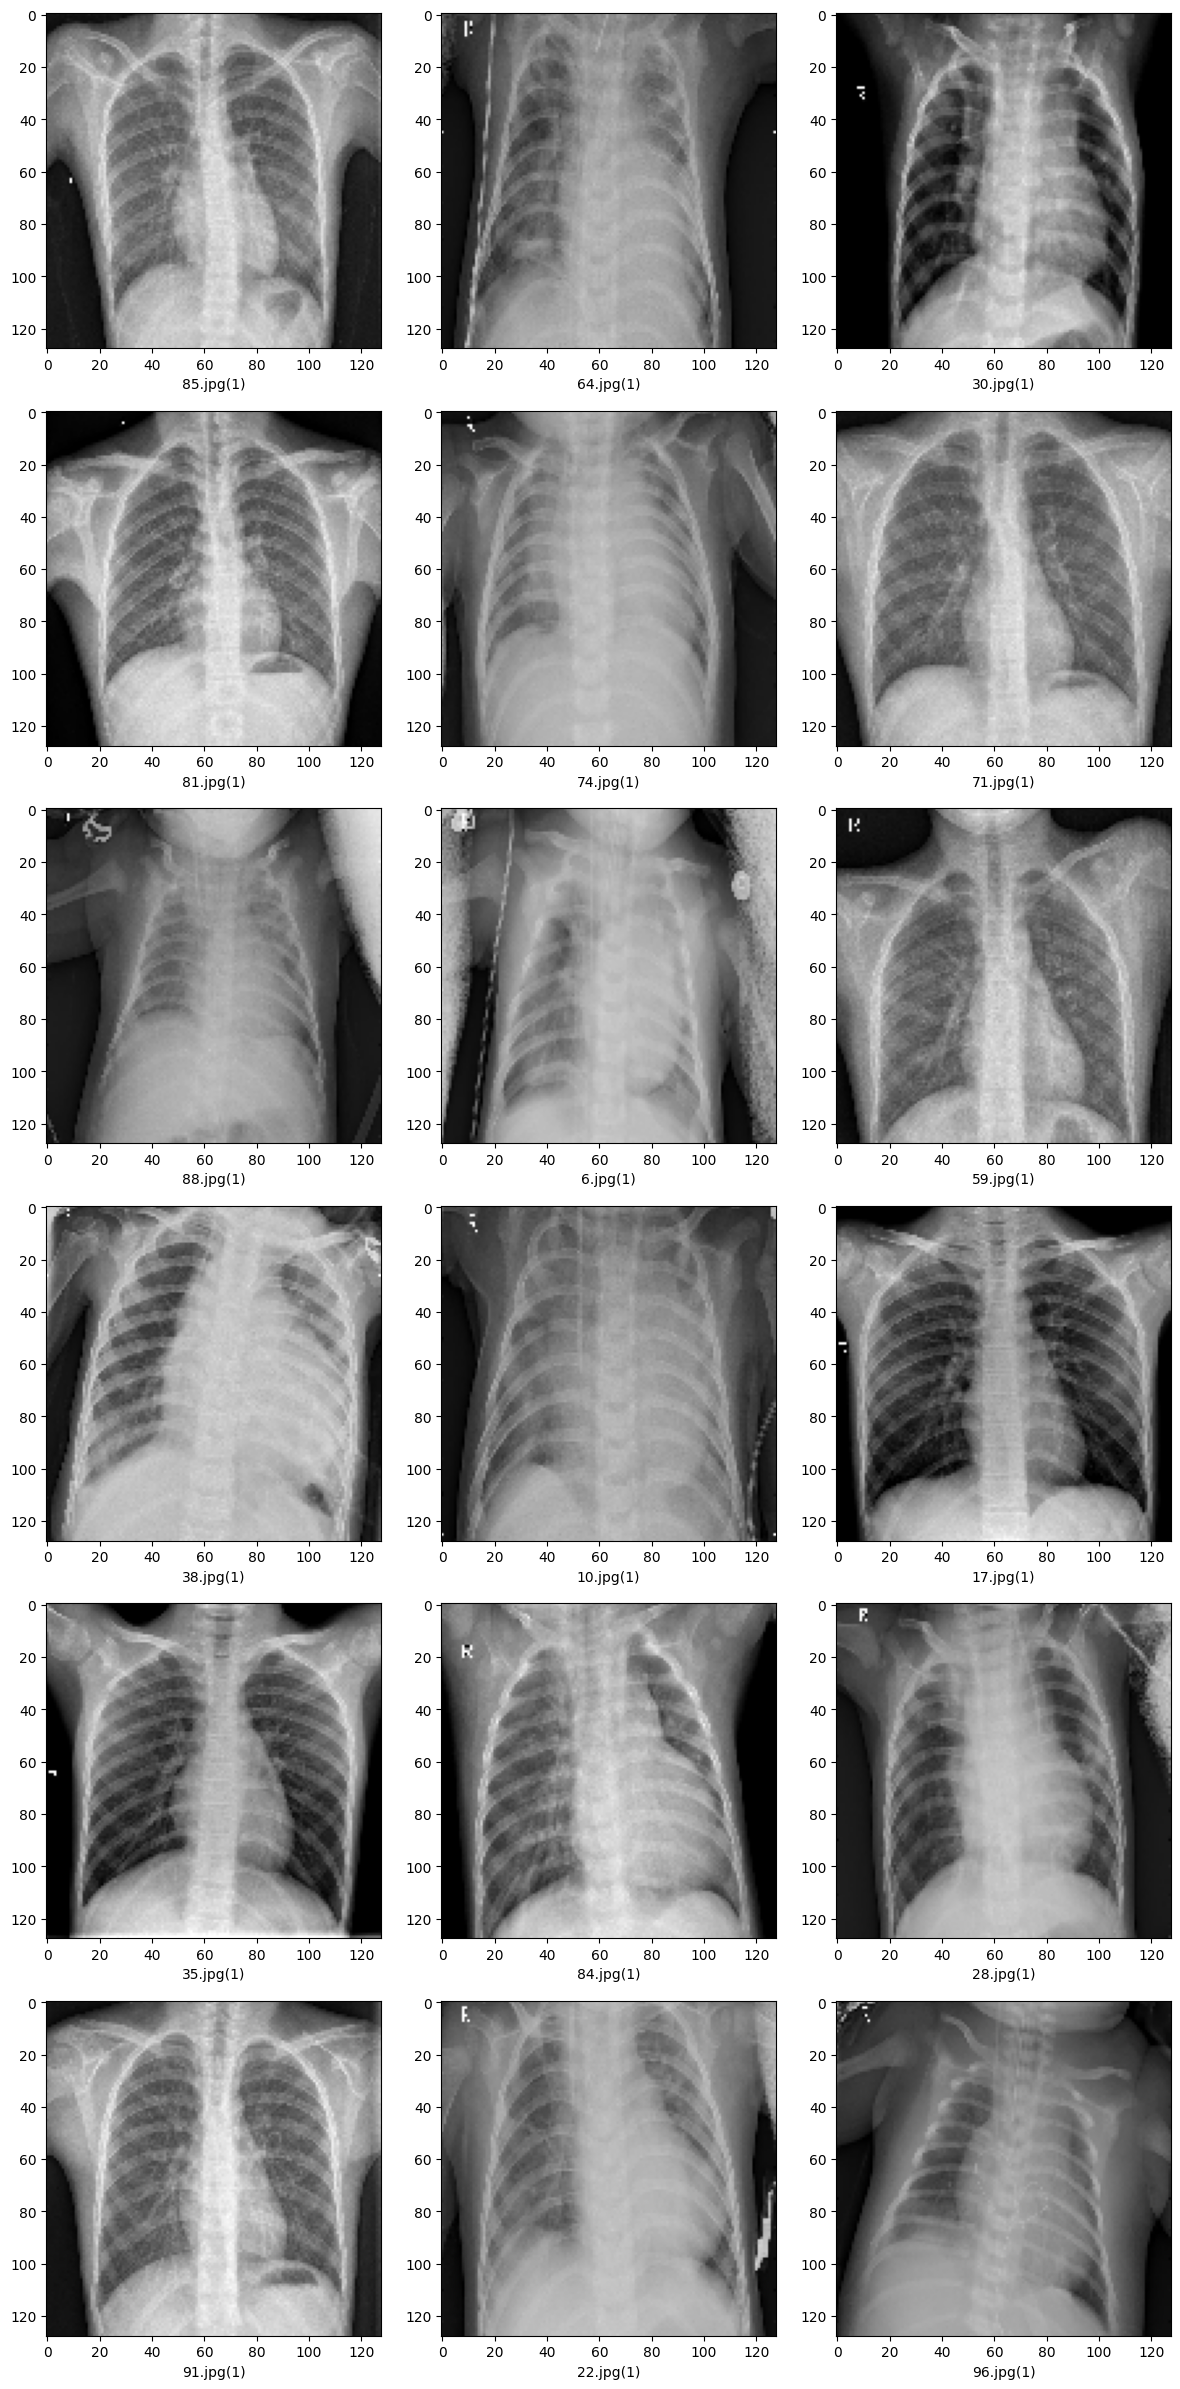

In [34]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/content/raio-x-torax/teste/"+filename, target_size=Image_Size)
# note que o caminho para a pasta TESTE deverá novamente ser apontado. Atente-se para não apagar as aspas e barras duplas.
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [35]:
# Instalação opcional da biblioteca, execute apenas se o passo 16 apresentar problema.
!pip install anaconda

  Preparing metadata (setup.py) ... done
  Created wheel for anaconda: filename=anaconda-0.0.1.1-py3-none-any.whl size=1095 sha256=efddbcea56cdebbc4c2cec321f837762767a59d1664c38c5a8894862a17e05e2
  Stored in directory: /root/.cache/pip/wheels/f4/0e/c2/43856d772ce2bfb88c8941fffeacf376a0fe9cb426543c5708
Successfully built anaconda


In [37]:
# Instale a biblioteca do OpenCV para o tratamento de imagens.
!pip install opencv-python

16. Testando o desempenho do modelo em dados personalizados:

In [48]:
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow import keras
import cv2
import random

1/1 [==============================] - 0s 40ms/step
[0.97097945 0.02902052]
Diagnóstico indicado: RX normal


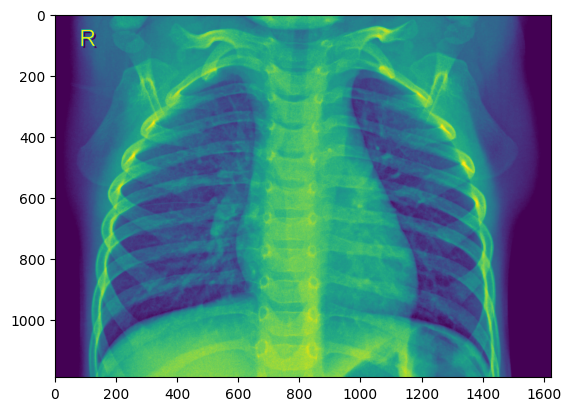

In [42]:
im=Image.open("/content/raio-x-torax/teste/1.jpg")
# note que o caminho para a pasta TESTE deverá novamente ser apontado. Atente-se para não apagar as aspas e barras duplas.
# escolha uma imagem para testar se é um raio x normal ou com pneumonia
img=im
im=im.resize(Image_Size)
im=(np.random.standard_normal([128,128,3])*255)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=model.predict([im])[0]

print(pred)

if pred[0] > pred[1]:
    print ('Diagnóstico indicado: RX normal')
else:
    print('Diagnóstico indicado: RX pneumonia')

plt.imshow(img)
plt.show()

1/1 [==============================] - 0s 97ms/step
[0.97627413 0.02372592]
Diagnóstico indicado: RX normal


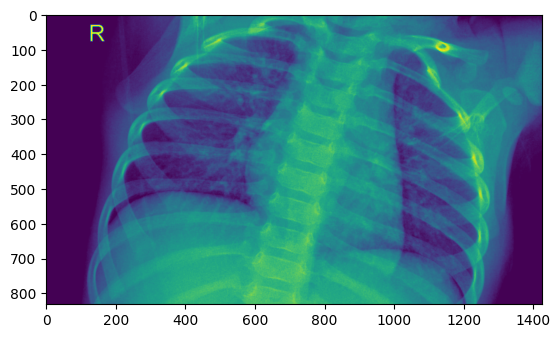

In [46]:
im=Image.open("/content/raio-x-torax/teste/3.jpg")
img=im
im=im.resize(Image_Size)
im=(np.random.standard_normal([128,128,3])*255)
im=np.expand_dims(im,axis=0)
im=np.array(im)
im=im/255
pred=model.predict([im])[0]

print(pred)

if pred[0] > pred[1]:
    print ('Diagnóstico indicado: RX normal')
else:
    print('Diagnóstico indicado: RX pneumonia')

plt.imshow(img)
plt.show()

In [93]:
def random_test_classify(is_test: bool):
  path = 'teste' if is_test else 'treino'
  image_path = random.choice(os.listdir(f"/content/raio-x-torax/{path}"))
  print('image name: ', image_path)

  im=Image.open(f"/content/raio-x-torax/{path}/{image_path}")
  img=im
  im=im.resize(Image_Size)
  im=(np.random.standard_normal([128,128,3])*255)
  im=np.expand_dims(im,axis=0)
  im=np.array(im)
  im=im/255
  pred=model.predict([im])[0]

  print(pred)

  if pred[0] > pred[1]:
      print ('Diagnóstico indicado: RX normal')
  else:
      print('Diagnóstico indicado: RX pneumonia')

  plt.imshow(img)
  plt.show()

image name:  pneumonia.17.jpeg
1/1 [==============================] - 0s 45ms/step
[0.9841345  0.01586548]
Diagnóstico indicado: RX normal


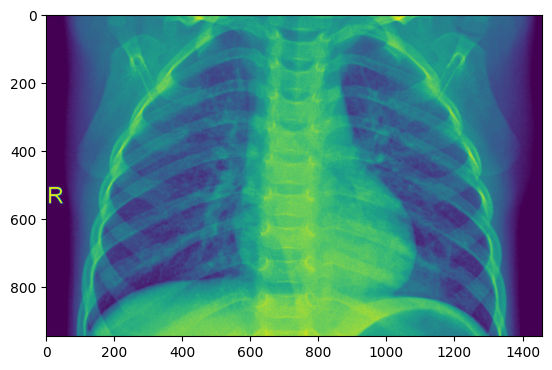

In [96]:
random_test_classify(is_test=False)

# Classificador GUI para imagens médicas

1. Intalando o Tkinter Python:

In [ ]:
!pip install tk

In [ ]:
import tkinter
tkinter.TkVersion

2. Gerando a GUI:

In [ ]:
import tkinter as tk
from tkinter import filedialog
from tkinter import *
from PIL import ImageTk, Image
import numpy
import os

from keras.models import load_model
model = load_model('modelo_raio-x-torax_10epoch.h5') # arquivo do modelo treinado

# Inicializando a GUI
top=tk.Tk()
top.geometry('800x600')
top.title('Classificação para raio-x de tórax')
top.configure(background='#CDCDCD')
label=Label(top,background='#CDCDCD', font=('arial',15,'bold'))
sign_image = Label(top)
def classify(file_path):
    global label_packed
    image = Image.open(file_path)
    image = (np.random.standard_normal([128,128,3])*255)
    image = numpy.expand_dims(image, axis=0)
    image = numpy.array(image)
    image = image/255
    pred = model.predict([image])[0]
    basename = os.path.basename(file_path)
    name = int(basename.rsplit('.', 1)[0])
    if name % 2:
         sign = 'Diagnóstico indicado: RX normal,'
    else:
         sign = 'Diagnóstico indicado: RX pneumonia,'
    print(sign)
    label.configure(foreground='#011638', text=f'{sign} {str(max(pred*100))} {str("%")}')

def show_classify_button(file_path):
    classify_b=Button(top,text="Classificar imagem",
   command=lambda: classify(file_path),
   padx=10,pady=5)
    classify_b.configure(background='#364156', foreground='white',
font=('arial',10,'bold'))
    classify_b.place(relx=0.79,rely=0.46)

def upload_image():
    try:
        file_path=filedialog.askopenfilename()
        uploaded=Image.open(file_path)
        uploaded.thumbnail(((top.winfo_width()/2.25),
    (top.winfo_height()/2.25)))
        im=ImageTk.PhotoImage(uploaded)
        sign_image.configure(image=im)
        sign_image.image=im
        label.configure(text='')
        show_classify_button(file_path)

    except:
        pass
upload=Button(top,text="Upload da imagem",command=upload_image,padx=10,pady=5)
upload.configure(background='#364156', foreground='white',font=('arial',10,'bold'))
upload.pack(side=BOTTOM,pady=50)
sign_image.pack(side=BOTTOM,expand=True)
label.pack(side=BOTTOM,expand=True)
heading = Label(top, text="Classificação para raio-x de tórax",pady=20, font=('arial',20,'bold'))
heading.configure(background='#CDCDCD',foreground='#364156')
heading.pack()
top.mainloop()